In [1]:
# pip install git+https://github.com/LucianoPereiraValenzuela/ECC_2025_testing.git 

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.svm import SVC 
import pandas as pd 
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, StatevectorSimulator

In [3]:
data_zoo = pd.read_csv("GalaxyZoo1_DR_table2.csv",  low_memory=False ) 
data_zoo = data_zoo[['OBJID', 'SPIRAL', 'ELLIPTICAL' ]]

data_ba = pd.read_csv("Barchi19_Morph-catalog_670k-galaxies.csv",  low_memory=False ) 
data_ba = data_ba[ ['dr7objid', 'TType', 'K', 'C', 'A', 'S', 'G2', 'H'] ]

data = pd.merge( data_zoo, data_ba, left_on='OBJID', right_on='dr7objid')
data = data[ data['C']>-2000]
data['type'] = data['SPIRAL'] + 2 *data['ELLIPTICAL'] 
data.head(5) 

,OBJID,SPIRAL,ELLIPTICAL,dr7objid,TType,K,C,A,S,G2,H,type
0,587727178986356823,0,0,587727178986356823,0.138666808605,17.640107,0.508223,0.770998,0.741028,1.497620,0.662460,0
1,587727227300741210,1,0,587727227300741210,2.4552721977200003,18.523393,0.377586,0.820991,0.872967,1.646847,0.753667,1
2,587727225153257596,0,0,587727225153257596,-0.9607127904889999,8.067093,0.429594,0.888312,0.782680,1.480424,0.641533,0
4,587731186203885750,0,0,587731186203885750,-2.0892539024400003,7.064457,0.455250,0.827402,0.669853,0.641865,0.545032,0
5,587727180060098638,0,0,587727180060098638,-1.9190112352400002,12.415233,0.549355,0.847826,0.840258,1.508247,0.716344,0


In [4]:
# 'TType', 'K', 'A', 'S', 'G2', 'H'
def select_data_random(data, N, columns=[ 'A', 'H' ] ):
    """
    data    : dataset
    N       : numero de datos para el entrenamiento o el test.
    columns : columnas correspondientes a las caractesiticas que usaremos.

    X_train : N vectores bidimensionales
    Y_train : N cantidades binarias
    """

    data0 = data[ data['SPIRAL'].isin([1]) ]
    data0_train = data0.sample(N//2)

    data1 = data[ data['ELLIPTICAL'].isin([1]) ]
    data1_train = data1.sample(N//2 + N%2)

    data_train = pd.concat([data0_train, data1_train], axis=0).sort_index()

    X = data_train[columns].to_numpy()#/ data_train[columns].max().to_numpy()
    # pca = PCA( 2 )
    # X = pca.fit( X.T ).components_.T
    Y = data_train['type'].to_numpy()-1
    
    return X, Y

In [5]:
N = 100
M = 50

#5  90 A H
np.random.seed(5)
X_train, Y_train = select_data_random(data,N)
X_test, Y_test   = select_data_random(data,M)
Y_train

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0])

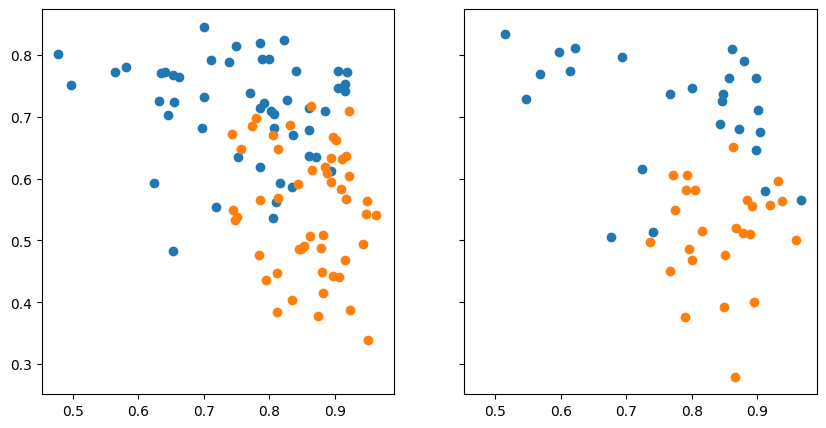

In [6]:
fig, axes = plt.subplots( 1,2 , figsize=( 10, 5 ), sharey = True, sharex = True )
axes[0].scatter( X_train[Y_train==0][:,0], X_train[Y_train==0][:,1] )
axes[0].scatter( X_train[Y_train==1][:,0], X_train[Y_train==1][:,1] )
axes[1].scatter( X_test[Y_test==0][:,0], X_test[Y_test==0][:,1] )
axes[1].scatter( X_test[Y_test==1][:,0], X_test[Y_test==1][:,1] )

In [7]:
def kernel_clasico( X_train, X_test=None ):
    """
    X_train : vector bidimensional para entrenar
    X_test  : vector bidimensional para testear
    K       : Kernel clasico
    """

    if X_test is None:
        X_test = X_train

    X_train = np.array(X_train)
    X_test  = np.array(X_test)
    K      = np.zeros(( X_test.shape[0], X_train.shape[0]))

    ######
    for j, x_test in enumerate( X_test ):
        for k, x_train in enumerate( X_train):
            K[j,k] = ( 1 + np.vdot( x_test, x_train ) )**2
    ######

    return K

In [8]:
K_train = kernel_clasico( X_train )
K_test  = kernel_clasico( X_train, X_test )

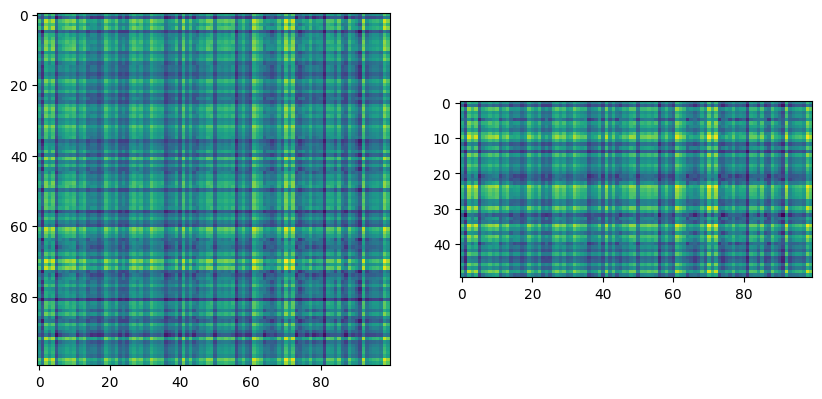

In [9]:
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
ax[0].imshow( K_train )
ax[1].imshow( K_test )

In [10]:
svm = SVC( kernel = 'precomputed' ).fit( K_train, Y_train )
Y_predict = svm.predict( K_test )
print( 'Datos de entrenamiento:',  Y_test)
print( 'Predicción:            ',  Y_predict)
print( 'Fidelidad train:       ', svm.score(K_train, Y_train) )
print( 'Fidelidad test:        ', svm.score(K_test, Y_test) )

Datos de entrenamiento: [1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0
 1 0 1 0 1 1 1 1 1 1 1 0 0]
Predicción:             [1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0
 1 0 1 0 1 1 1 1 1 1 1 0 0]
Fidelidad train:        0.81
Fidelidad test:         0.88


(0.2595637547969999, 0.8542503905300001)

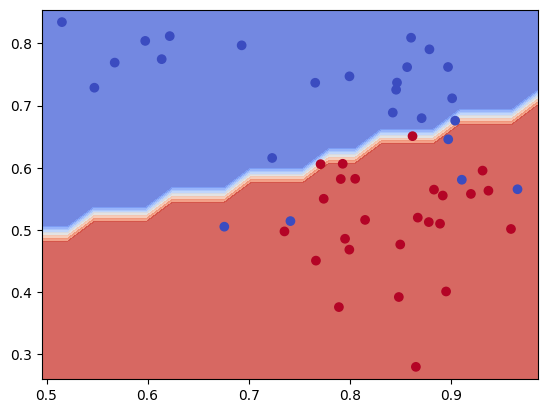

In [11]:
steps = 20
x_min, x_max = X_test[:, 0].min()-0.02, X_test[:, 0].max()+0.02
y_min, y_max = X_test[:, 1].min()-0.02, X_test[:, 1].max()+0.02
xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
Kq_plot = kernel_clasico( X_train, np.vstack([xx.ravel(),yy.ravel()]).T )
Z = svm.predict(Kq_plot).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [12]:
def circuit( x ):
    """
    x  : vector bidimensional
    qc : circuito cuantico
    """
    qc = QuantumCircuit(2, 2)

    ####
    qc.h(range(2))
    qc.ry( np.pi*x[0], 0 )
    qc.ry( np.pi*x[1], 1)
    qc.cx(0,1)
    qc.ry(np.pi**2*x[1]*x[0],1)  
    # qc.cx(0,1)
    # qc.rz(np.pi*x[0],0)  
    # qc.rz(np.pi*x[1],1)  
    ####

    return qc

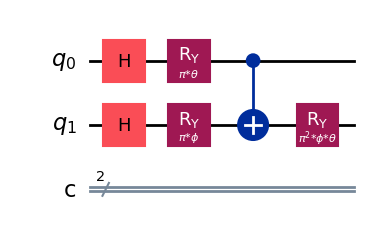

In [13]:
from qiskit.circuit import Parameter

theta = Parameter('$\\theta$')
phi = Parameter('$\\phi$')
qc1 = circuit( [ theta, phi ] )
qc1.draw('mpl')

In [14]:
def circuit_for_kernel_element(x_1, x_2 ):
    
    """ 
    x_1 : vector bidimensional
    x_2 : vector bidimensional
    qc  : circuito cuantico
    """

    qc = QuantumCircuit(2, 2)
    ####
    qc.compose( circuit(x_1), inplace=True )
    qc.compose( circuit(x_2).inverse(), inplace=True )
    qc.measure( range(2), range(2) )
    ####

    return qc

def Quantum_Kernel( X_train, X_test=None, backend=AerSimulator(), shots=1000 ):
    """ 
    X_train : vector bidimensional para entrenar
    X_test  : vector bidimensional para testear
    K_q     : Kernel cuantico
    backend : simulador o computador cuantico
    shots   : numero de shots     
    """

    if X_test is None:
        X_test = X_train
    X_train = np.array(X_train)
    X_test  = np.array(X_test)

    qcs = []
    for x_test in X_test:
        for x_train in X_train:
            qcs.append( circuit_for_kernel_element( x_train, x_test ) )

    ####
    job    = backend.run(qcs,shots=shots)#execute( qcs,backend )
    counts = job.result().get_counts() 
    ####

    K_q = np.zeros(( X_test.shape[0], X_train.shape[0]))
    ###
    l = 0
    for j, x_test in enumerate( X_test ):
        for k, x_train in enumerate( X_train):
            K_q[j,k] = float( counts[l]['00'] )/shots if '00' in counts[l] else 0
            l += 1
    ###

    return K_q

In [15]:
Kq_train = Quantum_Kernel( X_train )
Kq_test  = Quantum_Kernel( X_train, X_test )
# approx 40seg

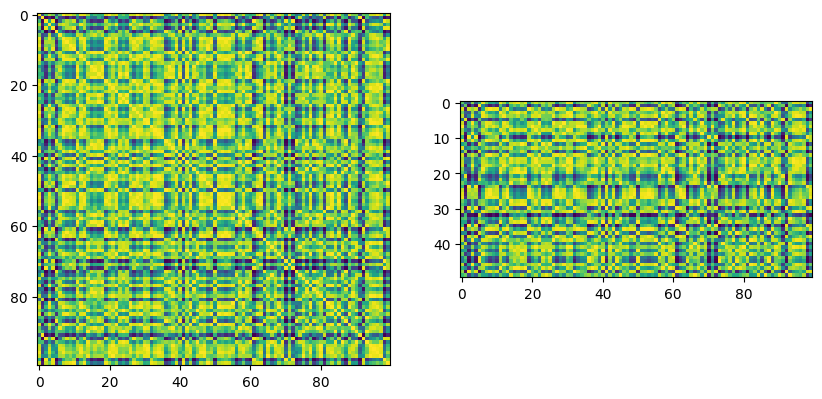

In [16]:
fig, ax = plt.subplots( 1, 2, figsize=(10,5) )
ax[0].imshow( Kq_train )
ax[1].imshow( Kq_test )

In [17]:
svm = SVC( kernel = 'precomputed' )
svm.fit( Kq_train, Y_train )
Y_pred_quantum = svm.predict(Kq_test)
print( 'Datos de entrenamiento:',  Y_test)
print( 'Predicción:            ',  Y_pred_quantum)
print( 'Fidelidad train:       ', svm.score( Kq_train, Y_train ) )
print( 'Fidelidad test:        ', svm.score( Kq_test, Y_test ) ) 

Datos de entrenamiento: [1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0
 1 0 1 0 1 1 1 1 1 1 1 0 0]
Predicción:             [1 1 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0
 1 0 1 0 1 1 1 1 1 1 1 0 0]
Fidelidad train:        0.8
Fidelidad test:         0.9


(0.2595637547969999, 0.8542503905300001)

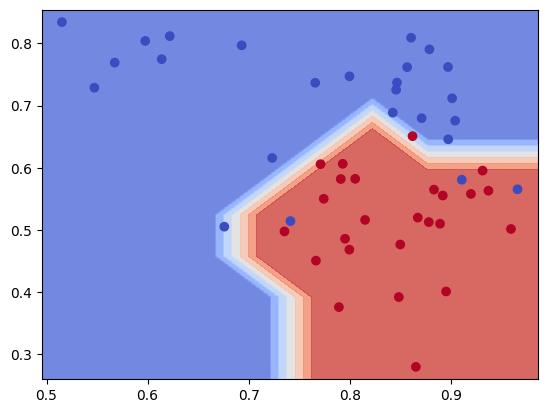

In [18]:
steps = 10
x_min, x_max = X_test[:, 0].min()-0.02, X_test[:, 0].max()+0.02
y_min, y_max = X_test[:, 1].min()-0.02, X_test[:, 1].max()+0.02
xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), 
                    np.linspace(y_min, y_max, steps))
Kq_plot = Quantum_Kernel( X_train, 
                        np.vstack([xx.ravel(),yy.ravel()]).T, 
                        StatevectorSimulator() )
Z = svm.predict(Kq_plot).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], 
            c=Y_test, cmap=plt.cm.coolwarm)
plt.xlim(xx.min(), xx.max()) 
plt.ylim(yy.min(), yy.max()) 